In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:
sales_df = pd.read_csv('/kaggle/input/salesfinal/SalesFINAL12312016.csv')

In [ ]:
sales_df.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   InventoryId     1048575 non-null  object 
 1   Store           1048575 non-null  int64  
 2   Brand           1048575 non-null  int64  
 3   Description     1048575 non-null  object 
 4   Size            1048575 non-null  object 
 5   SalesQuantity   1048575 non-null  int64  
 6   SalesDollars    1048575 non-null  float64
 7   SalesPrice      1048575 non-null  float64
 8   SalesDate       1048575 non-null  object 
 9   Volume          1048575 non-null  int64  
 10  Classification  1048575 non-null  int64  
 11  ExciseTax       1048575 non-null  float64
 12  VendorNo        1048575 non-null  int64  
 13  VendorName      1048575 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 112.0+ MB


In [ ]:
sales_df.shape

(1048575, 14)

In [ ]:
sales_df.describe()

,Store,Brand,SalesQuantity,SalesDollars,SalesPrice,Volume,Classification,ExciseTax,VendorNo
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.008063e+01,1.216959e+04,2.337619e+00,3.160420e+01,1.543162e+01,9.500280e+02,1.416550e+00,1.326847e+00,6.995043e+03
std,2.435739e+01,1.241921e+04,3.511492e+00,6.570249e+01,1.404967e+01,7.142708e+02,4.929872e-01,3.407898e+00,8.426736e+03
min,1.000000e+00,5.800000e+01,1.000000e+00,4.900000e-01,4.900000e-01,5.000000e+01,1.000000e+00,1.000000e-02,2.000000e+00
25%,1.500000e+01,3.680000e+03,1.000000e+00,1.099000e+01,8.990000e+00,7.500000e+02,1.000000e+00,1.600000e-01,3.252000e+03
50%,3.900000e+01,6.296000e+03,1.000000e+00,1.799000e+01,1.299000e+01,7.500000e+02,1.000000e+00,6.800000e-01,4.425000e+03
75%,6.400000e+01,1.795400e+04,2.000000e+00,3.199000e+01,1.899000e+01,1.500000e+03,2.000000e+00,1.570000e+00,9.552000e+03
max,7.900000e+01,9.008900e+04,4.320000e+02,1.327997e+04,4.999990e+03,2.000000e+04,2.000000e+00,3.785200e+02,1.733570e+05


In [ ]:
sales_df.isnull().sum()

InventoryId       0
Store             0
Brand             0
Description       0
Size              0
SalesQuantity     0
SalesDollars      0
SalesPrice        0
SalesDate         0
Volume            0
Classification    0
ExciseTax         0
VendorNo          0
VendorName        0
dtype: int64

In [ ]:
sales_df.duplicated().sum()

0

The data is clean with no missing values or duplicates

In [ ]:
sales_df['Brand'].nunique()

7658

The dataset spans 60 days with 7,658 unique brands, indicating high product diversity but a short time frame. **This influenced my decision to focus on total daily demand forecasting, as forecasting per brand would be sparse with only 60 days of data.**

In [ ]:
sales_df['SalesDate'].nunique()

60

In [ ]:
sales_df['Size'].nunique()

40

In [ ]:
sales_df['SalesDate'] = pd.to_datetime(sales_df['SalesDate'])

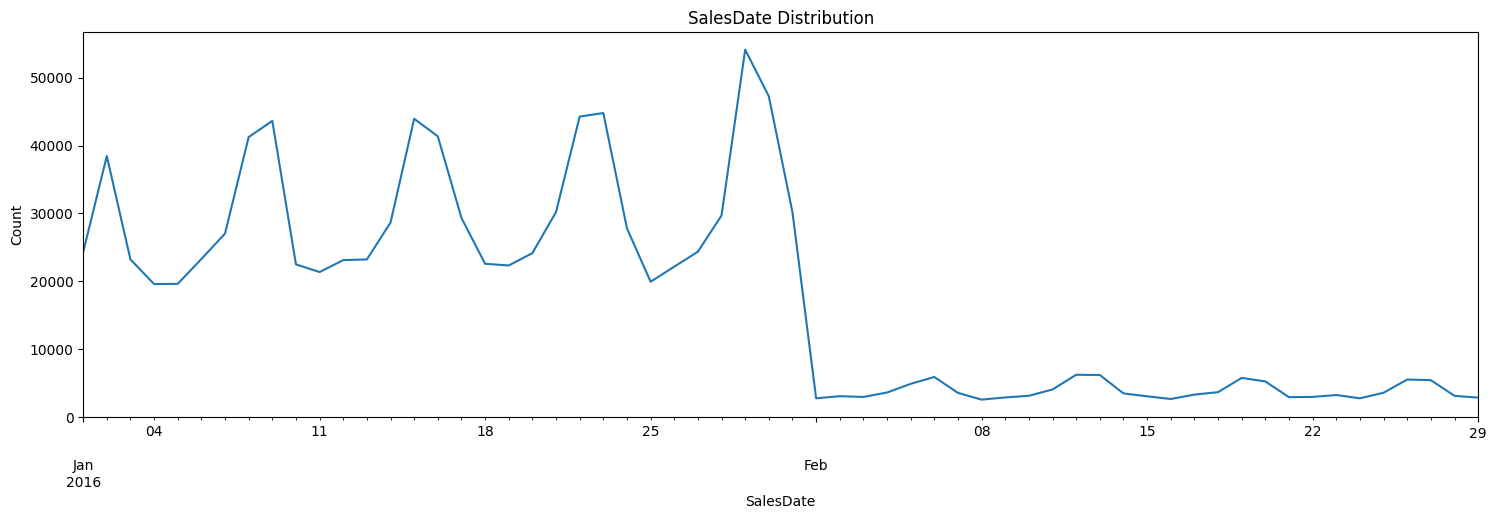

In [ ]:
plt.figure(figsize=(18, 5))
sales_df['SalesDate'].value_counts().sort_index().plot()
plt.title('SalesDate Distribution')
plt.xlabel('SalesDate')
plt.ylabel('Count')
plt.show()

**The SalesDate Distribution plot shows a sharp drop in February transactions (near 0 after Feb 8). This suggests incomplete data.**

The sales date plot revealed weekly patterns with peaks on weekends, which I captured using SARIMAX’s seasonal component. **I also noticed a sharp drop in February transactions, so I focused on January data (31 days) to avoid inconsistencies, ensuring more reliable forecasts**

In [ ]:
brand_quantity = sales_df.groupby('Brand')['SalesQuantity'].sum().sort_values(ascending=False)
display(brand_quantity.head())

Brand
8111    28544
1892    23121
4261    20226
3606    19200
5111    18411
Name: SalesQuantity, dtype: int64

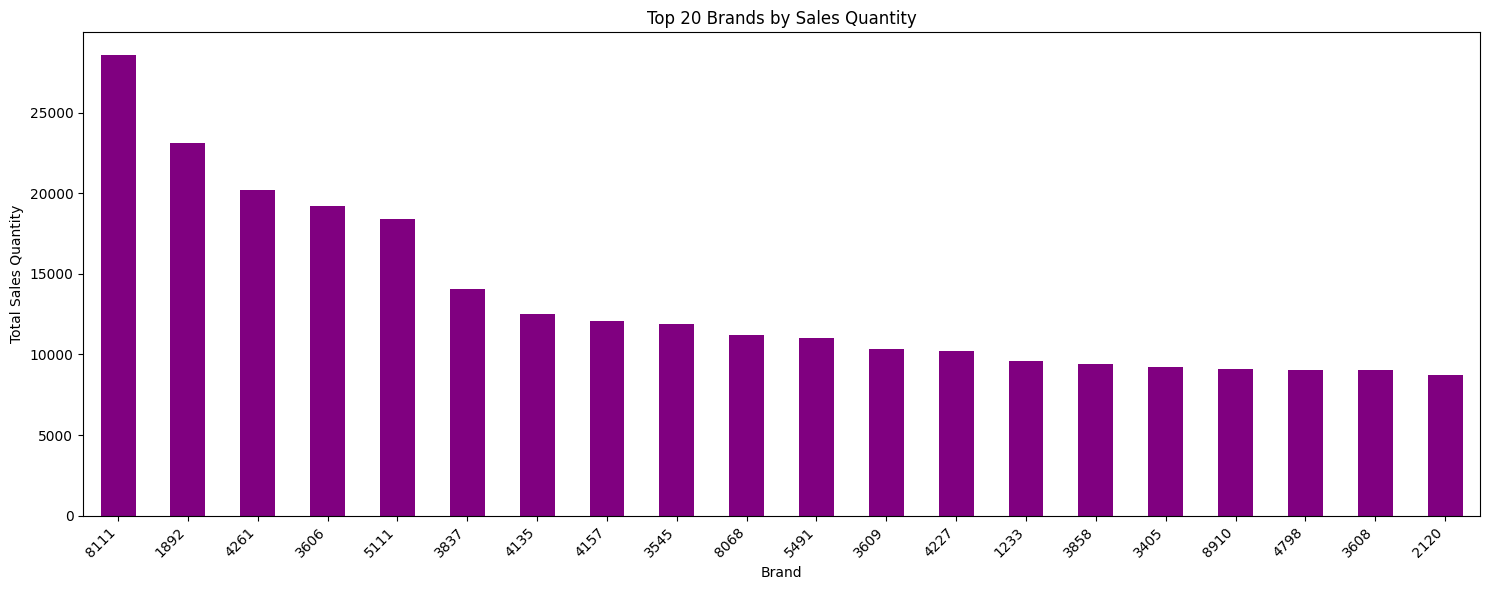

In [ ]:
plt.figure(figsize=(15, 6))
brand_quantity.head(20).plot(kind='bar', color='purple')
plt.title('Top 20 Brands by Sales Quantity')
plt.xlabel('Brand')
plt.ylabel('Total Sales Quantity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
brand_sales = sales_df.groupby('Brand')['SalesDollars'].sum().sort_values(ascending=False)
display(brand_sales.head())

Brand
4261    444810.74
3545    357759.17
1233    344712.22
8068    288135.11
3405    275162.97
Name: SalesDollars, dtype: float64

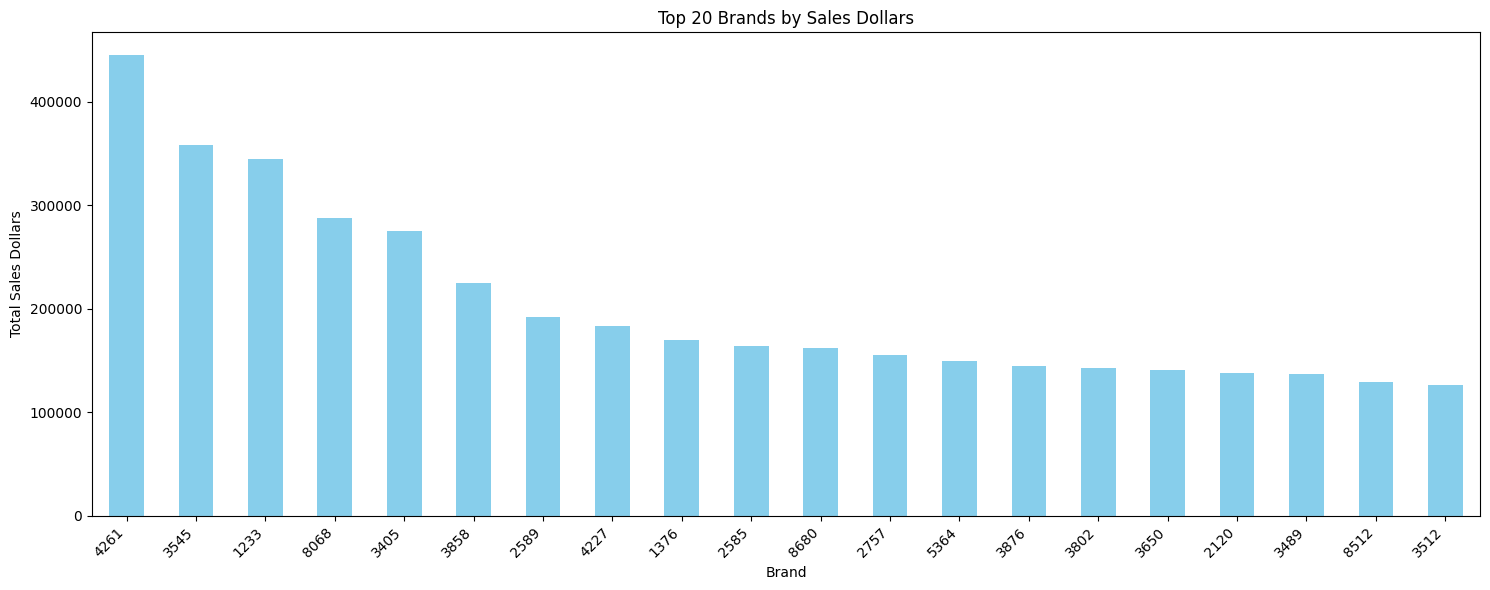

In [ ]:
plt.figure(figsize=(15, 6))
brand_sales.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Brands by Sales Dollars')
plt.xlabel('Brand')
plt.ylabel('Total Sales Dollars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Brand 4261 leads in SalesDollars ($444,810.74), while Brand 8111 leads in SalesQuantity (28,544 units). This indicates that high-value sales don’t always align with high-volume sales, likely due to price differences.**

In [ ]:
matrix = sales_df.corr(numeric_only=True)

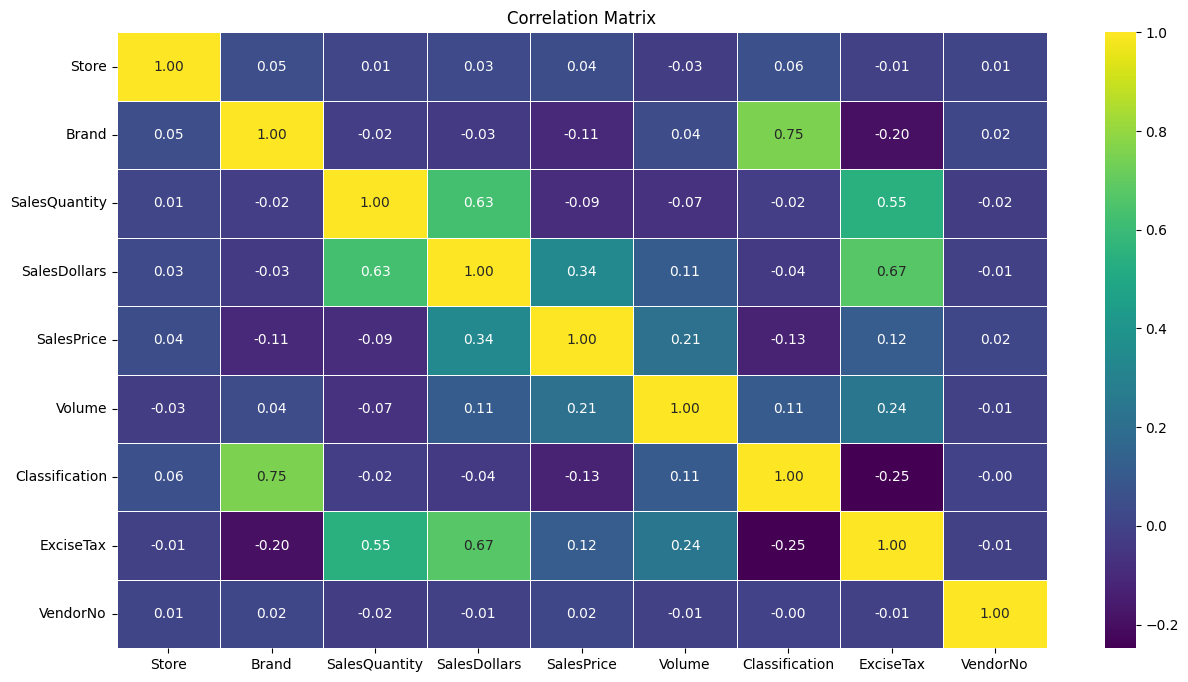

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.heatmap(matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

**SalesQuantity (your likely target for demand forecasting) is influenced by SalesDollars and ExciseTax**

In [ ]:
sales_df[['day', 'month', 'year']] = pd.DataFrame({
    'day': sales_df['SalesDate'].dt.day,
    'month': sales_df['SalesDate'].dt.month,
    'year': sales_df['SalesDate'].dt.year
})

In [ ]:
sales_df.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,day,month,year
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,1,1,2016
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750,1,1.57,12546,JIM BEAM BRANDS COMPANY,2,1,2016
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,3,1,2016
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,8,1,2016
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375,1,0.79,12546,JIM BEAM BRANDS COMPANY,9,1,2016


In [ ]:
sales_df.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification',
       'ExciseTax', 'VendorNo', 'VendorName', 'day', 'month', 'year'],
      dtype='object')

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   InventoryId     1048575 non-null  object        
 1   Store           1048575 non-null  int64         
 2   Brand           1048575 non-null  int64         
 3   Description     1048575 non-null  object        
 4   Size            1048575 non-null  object        
 5   SalesQuantity   1048575 non-null  int64         
 6   SalesDollars    1048575 non-null  float64       
 7   SalesPrice      1048575 non-null  float64       
 8   SalesDate       1048575 non-null  datetime64[ns]
 9   Volume          1048575 non-null  int64         
 10  Classification  1048575 non-null  int64         
 11  ExciseTax       1048575 non-null  float64       
 12  VendorNo        1048575 non-null  int64         
 13  VendorName      1048575 non-null  object        
 14  day             10

**Seasonal Autoregressive Integrated Moving Averages**



*   Visualize time-series-data
*   Make data stationary
*   Plot Correlation and AutoCorrelation charts
*   Construct ARIMA model or seasonal ARIMA based on the data
*   Use model to make predictions



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = ['Description', 'Size', 'VendorName']

# Apply label encoding to categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    sales_df[col] = le.fit_transform(sales_df[col])

In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   InventoryId     1048575 non-null  object        
 1   Store           1048575 non-null  int64         
 2   Brand           1048575 non-null  int64         
 3   Description     1048575 non-null  int64         
 4   Size            1048575 non-null  int64         
 5   SalesQuantity   1048575 non-null  int64         
 6   SalesDollars    1048575 non-null  float64       
 7   SalesPrice      1048575 non-null  float64       
 8   SalesDate       1048575 non-null  datetime64[ns]
 9   Volume          1048575 non-null  int64         
 10  Classification  1048575 non-null  int64         
 11  ExciseTax       1048575 non-null  float64       
 12  VendorNo        1048575 non-null  int64         
 13  VendorName      1048575 non-null  int64         
 14  day             10

In [ ]:
sales_df.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,day,month,year
0,1_HARDERSFIELD_1004,1,1004,3490,33,1,16.49,16.49,2016-01-01,750,1,0.79,12546,44,1,1,2016
1,1_HARDERSFIELD_1004,1,1004,3490,33,2,32.98,16.49,2016-01-02,750,1,1.57,12546,44,2,1,2016
2,1_HARDERSFIELD_1004,1,1004,3490,33,1,16.49,16.49,2016-01-03,750,1,0.79,12546,44,3,1,2016
3,1_HARDERSFIELD_1004,1,1004,3490,33,1,14.49,14.49,2016-01-08,750,1,0.79,12546,44,8,1,2016
4,1_HARDERSFIELD_1005,1,1005,4091,20,2,69.98,34.99,2016-01-09,375,1,0.79,12546,44,9,1,2016


In [ ]:
print(f"Total unique year in the dataset : ",sales_df['year'].nunique())
print(f"Total unique month in the dataset : ",sales_df['month'].nunique())
print(f"Total unique days in the dataset : ",sales_df['day'].nunique())

Total unique year in the dataset :  1
Total unique month in the dataset :  2
Total unique days in the dataset :  31


In [ ]:
sales_df['day'].duplicated().sum()

1048544

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(sales_df['day'], sales_df['SalesQuantity'], color='blue', label='SalesDollars')
plt.title('SalesQuantity Over Time')
plt.xlabel('Day')
plt.ylabel('SalesQuantity')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plt.bar(sales_df['day'], sales_df['SalesDollars'], color='orange', label='SalesQuantity')
plt.title('SalesDollars Over Time')
plt.xlabel('Day')
plt.ylabel('SalesDollars')
plt.legend()
plt.show()

**Both histograms (one for SalesDollars, one for SalesQuantity) show daily fluctuations with peaks around days 5, 10, 15, 20, and 30. This suggests possible weekly patterns (e.g., higher sales on weekends).**

# SARIMAX Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sales_df = sales_df[(sales_df['SalesDate'] >= '2016-01-01') & (sales_df['SalesDate'] <= '2016-01-31')]

In [ ]:
daily_sales = sales_df.groupby('SalesDate').agg({'SalesQuantity': 'sum', 'ExciseTax': 'mean'}).reset_index()
daily_sales.set_index('SalesDate', inplace=True)
daily_sales = daily_sales.asfreq('D', fill_value=0)

In [ ]:
# Step 3: Handle outliers and apply log transformation
sales_quantile_99 = daily_sales['SalesQuantity'].quantile(0.99)
daily_sales['SalesQuantity'] = daily_sales['SalesQuantity'].clip(upper=sales_quantile_99)
daily_sales['SalesQuantity'] = np.log1p(daily_sales['SalesQuantity'])  # Log transform

In [ ]:
daily_sales['day_of_week'] = daily_sales.index.dayofweek  # 0 = Monday, 6 = Sunday

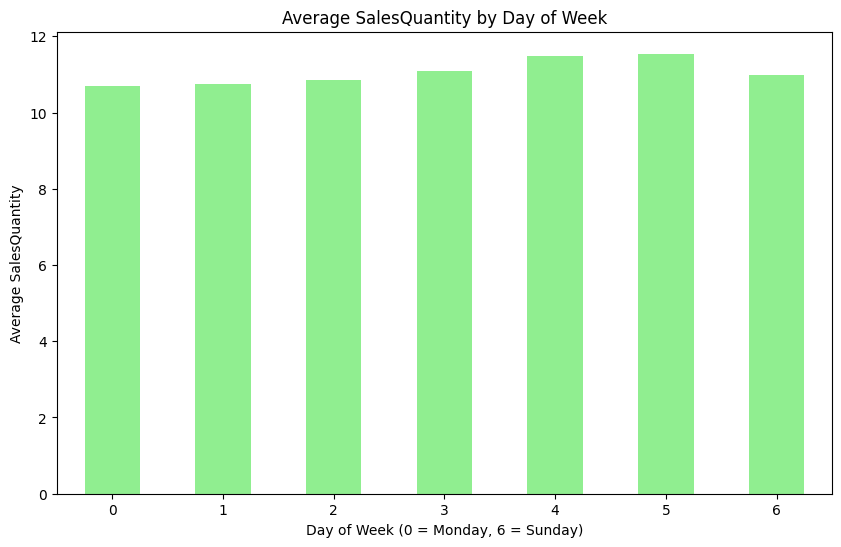

In [ ]:
plt.figure(figsize=(10, 6))
daily_sales.groupby('day_of_week')['SalesQuantity'].mean().plot(kind='bar', color='lightgreen')
plt.title('Average SalesQuantity by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average SalesQuantity')
plt.xticks(rotation=0)
plt.show()

In [ ]:
result = adfuller(daily_sales['SalesQuantity'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    print("Series is non-stationary, applying differencing...")
    daily_sales['SalesQuantity_diff'] = daily_sales['SalesQuantity'].diff().dropna()
else:
    print("Series is stationary, no differencing needed.")
    daily_sales['SalesQuantity_diff'] = daily_sales['SalesQuantity']

ADF Statistic: -1.1235722440683713
p-value: 0.7055806171650388
Series is non-stationary, applying differencing...


In [ ]:
# Step 5: Train-test split (Jan 1 - Jan 24 for training, Jan 25 - Jan 31 for testing)
train = daily_sales['SalesQuantity'][:27]  # Jan 1 to Jan 24
test = daily_sales['SalesQuantity'][27:]   # Jan 25 to Jan 31
train_excise_tax = daily_sales['ExciseTax'][:27]
test_excise_tax = daily_sales['ExciseTax'][27:]

In [ ]:
print(f"This is training data : ",train.shape)
print(f"This is testing data : ",test.shape)

This is training data :  (20, 6)
This is testing data :  (4, 6)



* The original dataset had 1,048,575 rows and 14 columns because it recorded every single sale (over a million transactions) across 60 days, with details like the date, brand, store, and quantity sold.
* For forecasting total daily demand, I didn’t need all those details—I just needed the total items sold each day.
* So, I added up the SalesQuantity for each day, which reduced the data to one row per day.
* Since I focused on January (31 days), that gave me 31 rows. Then, I split this into training (Jan 1 - Jan 27, 27 days) and testing (Jan 28 - Jan 31, 4 days) to build and test the model.


In [ ]:
# Step 6: Grid search for SARIMA parameters (simplified for demonstration)
best_aic = float('inf')
best_order = None
best_seasonal_order = None
orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2)]  # d=1 for non-stationarity
seasonal_orders = [(1, 1, 1, 7), (2, 1, 1, 7), (1, 1, 2, 7)]  # D=1 for seasonal differencing

for order in orders:
    for seasonal_order in seasonal_orders:
        try:
            model = SARIMAX(train, exog=train_excise_tax, order=order, seasonal_order=seasonal_order)
            sarima_model = model.fit(disp=False)
            if sarima_model.aic < best_aic:
                best_aic = sarima_model.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f"Best Order: {best_order}, Best Seasonal Order: {best_seasonal_order}, Best AIC: {best_aic}")

Best Order: (1, 1, 1), Best Seasonal Order: (1, 1, 1, 7), Best AIC: -23.902004136578043


In [ ]:
model = SARIMAX(train, exog=train_excise_tax, order=best_order, seasonal_order=best_seasonal_order)
sarima_model = model.fit(disp=False)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                     SalesQuantity   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  17.951
Date:                           Tue, 10 Jun 2025   AIC                            -23.902
Time:                                   16:27:35   BIC                            -18.235
Sample:                               01-01-2016   HQIC                           -22.943
                                    - 01-27-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ExciseTax      1.7295      0.281      6.164      0.000       1.180       2.279
ar.L1         -0.2702      1.882     -0.144

In [ ]:
forecast = sarima_model.forecast(steps=4, exog=test_excise_tax)
forecast = np.expm1(forecast)  # Reverse log transformation
test_actual = np.expm1(test)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_actual, forecast))
print(f"RMSE: {rmse}")

RMSE: 14801.54408852421


* RMSE, or Root Mean Squared Error, tells us how far off our model’s predictions are from the actual numbers, in the same units as our data. For example, our model predicts daily sales, and the RMSE is 14,801.
* This means, on average, our predictions are off by about 14,801 units per day. I’m using RMSE because it’s the best way to measure how well our model predicts sales quantities, which can be any number (like 5,000 or 16,000 units).
* Accuracy, on the other hand, is for classification tasks—like predicting "yes or no", "spam or not spam", "dog, cat, bird, fish" etc

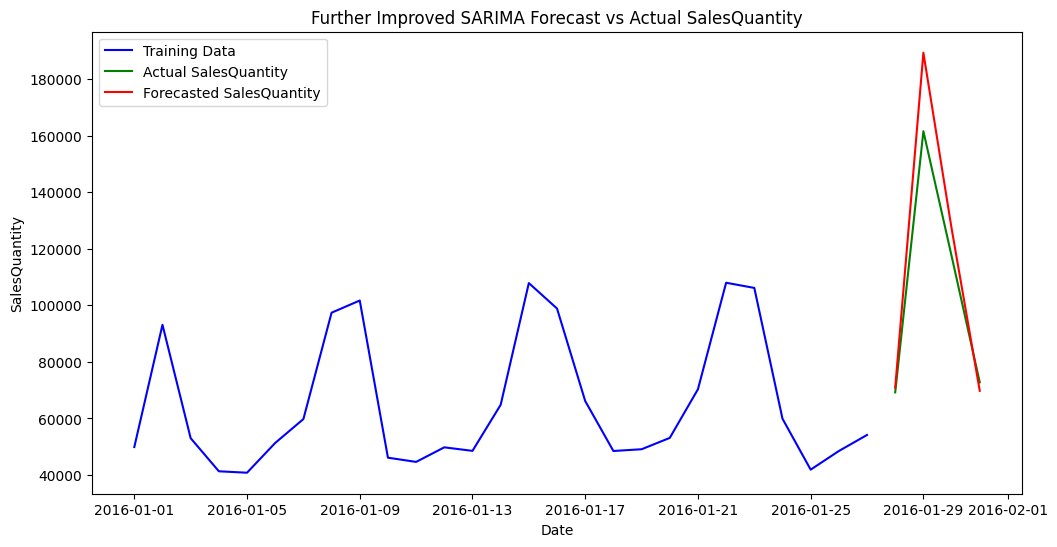

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, np.expm1(train), label='Training Data', color='blue')
plt.plot(test.index, test_actual, label='Actual SalesQuantity', color='green')
plt.plot(test.index, forecast, label='Forecasted SalesQuantity', color='red')
plt.title('Further Improved SARIMA Forecast vs Actual SalesQuantity')
plt.xlabel('Date')
plt.ylabel('SalesQuantity')
plt.legend()
plt.show()

# **XGBOOST MODEL**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
daily_sales['lag_1'] = daily_sales['SalesQuantity'].shift(1)
daily_sales['lag_7'] = daily_sales['SalesQuantity'].shift(7)
daily_sales = daily_sales.dropna()

In [ ]:
train = daily_sales[:20]  # Jan 2 to Jan 25 (after dropping NaNs)
test = daily_sales[20:]   # Jan 26 to Jan 31
X_train = train[['lag_1', 'lag_7', 'day_of_week', 'ExciseTax']]
y_train = train['SalesQuantity']
X_test = test[['lag_1', 'lag_7', 'day_of_week', 'ExciseTax']]
y_test = test['SalesQuantity']

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Forecast with XGBoost
xgb_forecast = xgb_model.predict(X_test)
xgb_forecast = np.expm1(xgb_forecast)  # Reverse log transformation
y_test_actual = np.expm1(y_test)  # Reverse log transformation

In [ ]:
# Evaluate XGBoost
xgb_rmse = np.sqrt(mean_squared_error(y_test_actual, xgb_forecast))
print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost RMSE: 29483.604738605325


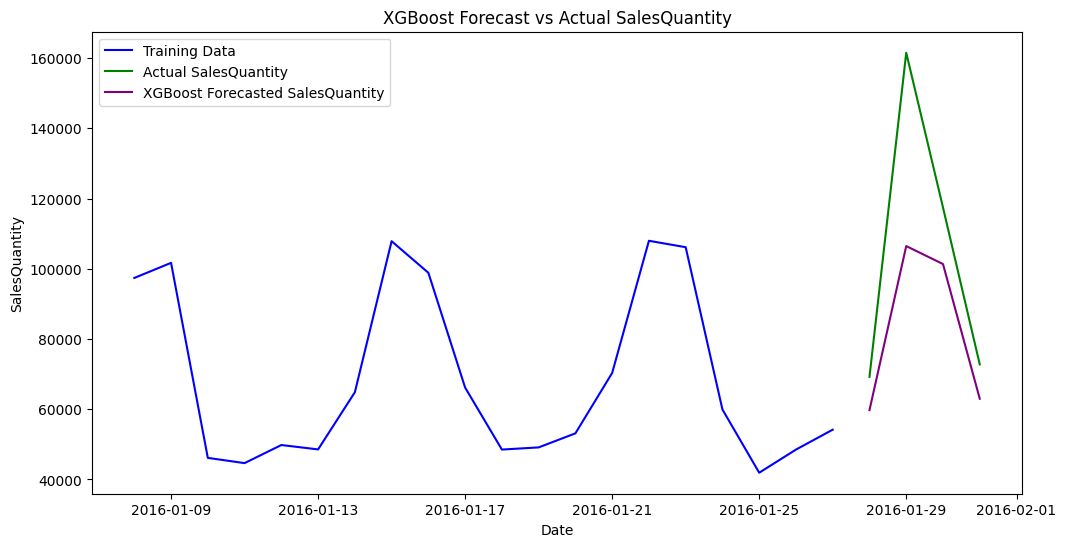

In [ ]:
# Visualize XGBoost forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, np.expm1(train['SalesQuantity']), label='Training Data', color='blue')
plt.plot(test.index, y_test_actual, label='Actual SalesQuantity', color='green')
plt.plot(test.index, xgb_forecast, label='XGBoost Forecasted SalesQuantity', color='purple')
plt.title('XGBoost Forecast vs Actual SalesQuantity')
plt.xlabel('Date')
plt.ylabel('SalesQuantity')
plt.legend()
plt.show()

# RandomForest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rf_forecast = rf_model.predict(X_test)
rf_forecast = np.expm1(rf_forecast)  # Reverse log transformation
y_test_actual = np.expm1(y_test)  # Reverse log transformation

In [ ]:
rf_rmse = np.sqrt(mean_squared_error(y_test_actual, rf_forecast))
print(f"RandomForest RMSE: {rf_rmse}")

RandomForest RMSE: 29751.21043837577


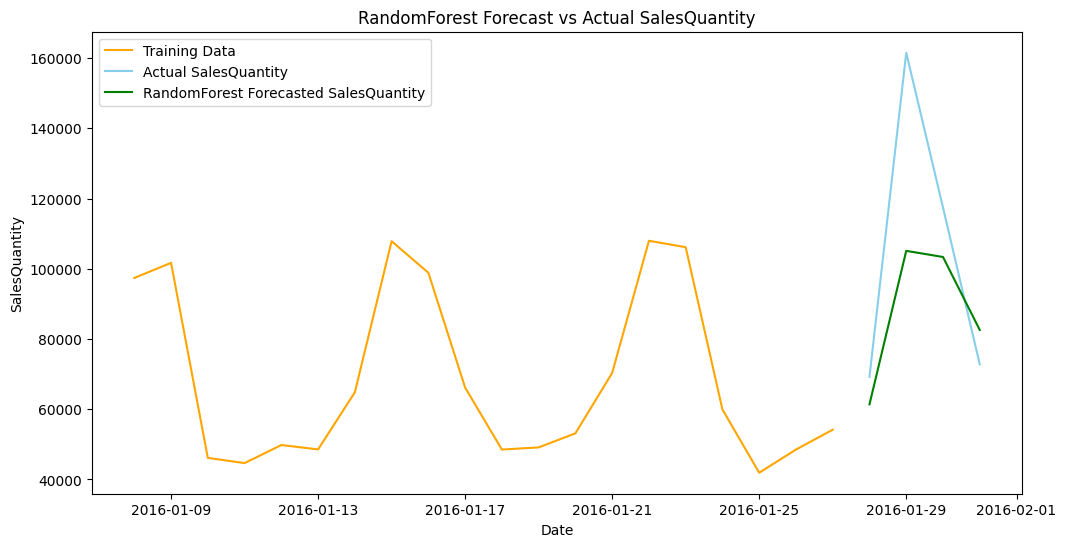

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, np.expm1(train['SalesQuantity']), label='Training Data', color='orange')
plt.plot(test.index, y_test_actual, label='Actual SalesQuantity', color='skyblue')
plt.plot(test.index, rf_forecast, label='RandomForest Forecasted SalesQuantity', color='green')
plt.title('RandomForest Forecast vs Actual SalesQuantity')
plt.xlabel('Date')
plt.ylabel('SalesQuantity')
plt.legend()
plt.show()

# SARIMAX Model shows the best results
SARIMAX because the data showed clear weekly seasonality, and with only 60 days, a model that explicitly handles seasonal patterns was ideal. SARIMAX also allowed me to include ExciseTax as an exogenous variable, improving the model’s ability to explain sales variations.

The SARIMAX model (RMSE: 14,801) :

* Buffer Stock: Add 14,801 units to your daily forecast as a safety buffer, since the model’s predictions can be off by this amount on average. For example, if the forecast is 50,000 units, plan for 64,801 units to avoid shortages.
* Weekend Boost: The model shows higher sales on Fridays and Saturdays. Stock 10-20% more than the forecast on these days to meet the extra demand.
* Daily Adjustments: Use the forecasted daily SalesQuantity from the model (e.g., from the January plot) to set base inventory levels, then adjust with the buffer.
